# What is a time series?

A *time series* is a a set of observations over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly. 

There are two kinds of features that are unique to time series: 

- time-step features and 
- lag features. 

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the *time dummy*, which counts off time steps in the series from beginning to the end. The *time-step* feature lets you model **time dependence**. A series is time dependent if its values can be predicted from the time they occured. 

To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Lag features let us model **serial dependence**. A time series has serial dependence when an observation can be predicted from the previous observation. 

## What is a trend in a time series?

The **trend** component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of market expansion as more people become aware of the product year by year. The trend can be linear, exponential, logarithmic or S-shaped.

Here we will focus on trends in the mean. In general though, any persistent and slow-moving change in a series could constitute a trend. Time series commonly have trends in their variance as well. 

### Moving average plots

To see what kind of trend a time series might have, we can use a **moving average plot**. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window. The idea is to smooth out short-term fluctuations in the series so that only long-term changes remain. To visualize a trend we take an average over a period longer than any seasonal period in the series. 

Once we've identified the shape of the trend we can attempt to model it using a time-step feature. We've already seen how the time dummy itself will model a linear trend. If we would like to fit a quadratic trend, we could use the square of the time dummy as an additional feature. 

## What is seasonality?

We say that a time series exhibits **seasonality** whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar (e.g., hourly, daily, weekly, monthly, quarterly, yearly). Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behaviour surrounding dates and times. The magnitude of seasonal effects can be constant (additive seasonality) or proportional to the trend (multiplicative seasonality). Some examples are:

- retail sales peak during holiday seasons
- electricity consumption being higher during the morning and evening and lower at night
- ice cream sales increasing in summer months and decreasing in winter months every year
- website traffic peaking on weekdays and dropping on weekends.

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations. 

### Seasonal plots and seasonal indicators

Just like we used a moving average plot to discover the trend in a series, we can use a **seasonal plot** to discover seasonal patterns. A seasonal plot shows segments of the time series plotted against some common period, the period being the season you want to observe. 

**Seasonal indicators** are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding. 

By one-hot encoding days of the week we get weekly seasonal indicators. 

### Fourier features and the periodogram

The kind of feature we discuss now are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine. 

**Fourier features** are pairs of sine and cosine curves, one pair for each potential frequency in the season, starting with the longest. Fourier pairs modelling annual seasonality would have frequencies: one per year, twice per year, three times per year and so on. If we add these sine / cosine curves to our training data, the linear regression algorithm will fit the weights that describe the seasonal component in the target series. 

### Choosing Fourier features with the periodogram

The periodogram indicates how many Fourier pairs we should actually include in the feature set. The **periodogram** gives the strength of the frequencies in a time series. Specifically, the value of the $y$-axis of the graph is $(a^2 + b^2)/2$ where $a$ and $b$ are the coefficients of the sine and cosine at that frequency. 

## What is serial dependence?

So far, we investigated properties of time series that were easily modelled as time dependent properties, that is, with features derived directly from the time index. Some time series properties, however, can only be modelled as serially dependent properties, that is using as features past values of the target series. The structure of these series may not be apparent from a plot over time; plotted against past values, however, the structure becomes clear. Using trend and seasonality the time dependence of a series can be learned. 

### Cycles

One especially common way for serial dependence to manifest itself is in **cycles**. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself. The cyclic component describes **fluctuations around the trend that are not of a fixed period**. Cyclic behaviour is characteristic of systems that can affect themselves or whose reactions persist over time. Economies, epidemics, animal populations, volcano eruptions and similar natural phenomena often display cyclic behaviour.

What distinguishes cyclic behaviour from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past. The (at least relative) independence from time means that cyclic behaviour can be much more irregular than seasonality.

### Lagged series and lag plots

To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. **Lagging** a time series means to shift its values forward one or more time steps, or equivalently, to shift the series in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time. 

The most common measure for serial dependence is **autocorrelation**, which is simply the correlation a time series has with one of its lags. When choosing lags as features, it generally won't be useful to include every lag that has a large autocorrelation. The **partial autocorrelation** tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use. When plotting the partial correlation, we obtain a correlogram. The correlogram is for lag features essentially what the periodogram is for Fourier features. 

Finally, we need to be mindful that autocorrelation and partial autocorrelation are measures of **linear dependence**. Because real-world time series often have substantial non-linear dependencies, it's best to look at a lag plot (or some more general measure of dependence like **mutual information**) when choosing lag features. 

A common limitation of using lag features is that the model needs a time step to react to suddent changes in the target series. To improve the forecast we could try to find **leading indicators**, i.e., a time series that could provide an "early warning". 

## Hybrid models

Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. In this section we'll create "hybrid" forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other. 

### Components and residuals

To design effective hybrids, we need to better understand how time series are constructed. So far, we have seen three patterns of dependence: trends $T$, seasons $SZ$ and cycles $C$. Many time series can be described by an additive model of these three components plus an entirely random, unpredictable error $E$:
$$
S(t) = T(t) + SZ(t) + C(t) + E(t)
$$
We call each term in this model a **component** of the time series. 

The **residuals** of a model are the difference between the target the model was trained on and the predictions the model makes, i.e., the difference between the actual and predicted curves. By plotting the residuals against a feature the "left over" part of the target can be seen, or what the model failed to learn about the target from that feature.

We could imagine learning the components of a time series as an iterative process: first learn the trend and subtract it out from the series, then learn the seasonality from the detrended series and subtract the seasons out, then learn the cycles and subtract the cycles out and finally only the unpredictable error remains. 

Instead of using one algorithm to learn all components, we could use one algorithm to learn some of the components and another algorithm for the rest. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series. The process looks like

``` python
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2
```

We'll usually want to use different feature sets depending on what we want each model to learn. For example, if we use the first model to learn the trend, we generally wouldn't need a trend feature for the second model. 

While it's possible to use more than two models, in practice it doesn't seem to be especially useful. In fact, the most common strategy for constructing hybrids is the one we've just described: a simple (usually linear) learning algorithm, followed by a complex, non-linear one like GBDTs or a deep neural net. 

### Designing hybrids

There are many ways you could combine ML models besides the way we've outlined in this lesson. Successfully combining models, though, requires a deeper understanding of how these models operate. 

There are generally two ways a regression algorithm can make predictions: either by transforming the features or by transforming the target. Feature-transforming algorithms learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind. 

Target-transforming algorithms use the features to group the target values in the training set and make predictions by averaging values in a group; a set of features indicates which group to average. Decision trees and nearest neighbors are of this kind. 

The important thing is this: feature transformers generally can extrapolate target values beyond the training set given appropriate features as inputs, but the predictions of target transformers will always be bound within the range of the training set. If the time dummy continues counting time steps, linear regression continues drawing a trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future, forever. Decision trees cannot extrapolate trends. Random forests and gradient boosted decision trees are ensembles of decision trees, so they also cannot extrapolate trends. 

This difference is what motivates the hybrid design: use linear regression to extrapolate the trend, transform the target to remove the trend and apply XGBoost to the detrended residuals. To hybridize a neural net you could instead include predictions of another model as a feature, which the neural net would include as part of its own predictions. The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we call these **boosted** hybrids; the method of using predictions as features is known as stacking, so we call these **stacked** hybrids. 

## Defining the forecasting task

The are two things to establish before designing a forecasting model:

- what information is available at the time a forecast is made (features)
- the time period during which you require forecasted values (target).

The **forecast origin** is time at which you are making a forecast. Practically, you might consider the forecast origin to be the last time for which you have training data for the time being predicted. Everything up to the origin can be used to create features. 

The **forecast horizon** is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon.

The time between the origin and the horizon is the **lead time** (or sometimes latency) of the forecast. A forecast's lead time is described by the number of steps from origin to horizon. In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing. 

### Preparing data for forecasting

In order to forecast time series with ML algorithms, we need to transform the series into a dataframe we can use with those algorithms (unless, of course, you are only using deterministic features like trend and seasonality). This process can start by creating a feature set out of lags. The process then continues by preparing the target, depending on the forecasting task. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split

In [2]:
def score_dataset(model, X_train, X_valid, y_train, y_valid):
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return y_pred, mean_absolute_error(y_valid, y_pred)

In [3]:
data_dir = Path('./data/store-sales-time-series-forecasting/')

oil_data = pd.read_csv(data_dir/'oil.csv', 
                       index_col='date', 
                       parse_dates=['date'])
oil_data.index = oil_data.index.to_period('D')

holidays_events = pd.read_csv(
    data_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date']
    )
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(data_dir/'train.csv', 
                          dtype={
                              'store_nbr': 'category',
                              'family': 'category',
                              'sales': 'float32',
                              'onpromotion': 'uint64'
                              },
                          parse_dates=['date']
                          )

# store_sales = store_sales.set_index('date').to_period('D')
# store_sales = store_sales.set_index(['store_nbr', 'family'], append=True).sort_index()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

# # average across all product types and stores versus day
average_sales = store_sales.groupby('date').mean()['sales'].to_frame()

# Select average sales for a specific year
selected_year = '2017'
average_sales = average_sales.loc[selected_year]

# Average sales for each product family and a specific year
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

/var/folders/ck/pm8w65g14tq15g3dw1vpfs980000gn/T/ipykernel_10071/3159601584.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['family', 'date'])


In [96]:
per_store_sales['10']

date
2013-01-01      0.000000
2013-01-02    164.548111
2013-01-03    137.864532
2013-01-04    102.455032
2013-01-05    163.932877
                 ...    
2017-08-11    179.763000
2017-08-12    191.600250
2017-08-13    205.258850
2017-08-14    188.992157
2017-08-15    206.260361
Freq: D, Name: sales, Length: 1684, dtype: float32

In [5]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [30]:
y = average_sales.copy()
y

,sales
date,
2017-01-01,6.780303
2017-01-02,786.928406
2017-01-03,619.740234
2017-01-04,555.607971
2017-01-05,436.375397
...,...
2017-08-11,463.733856
2017-08-12,444.798309
2017-08-13,485.768616


In [31]:
X = make_lags(y, lags=4).fillna(0.0)
X

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
,sales,sales,sales,sales
date,,,,
2017-01-01,0.000000,0.000000,0.000000,0.000000
2017-01-02,6.780303,0.000000,0.000000,0.000000
2017-01-03,786.928406,6.780303,0.000000,0.000000
2017-01-04,619.740234,786.928406,6.780303,0.000000
2017-01-05,555.607971,619.740234,786.928406,6.780303
...,...,...,...,...
2017-08-11,365.536987,411.975128,402.786957,447.511200
2017-08-12,463.733856,365.536987,411.975128,402.786957


In [32]:
y = make_multistep_target(y, steps=8).dropna()
y

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
,sales,sales,sales,sales,sales,sales,sales,sales
date,,,,,,,,
2017-01-01,6.780303,786.928406,619.740234,555.607971,436.375397,471.156158,619.419922,669.216492
2017-01-02,786.928406,619.740234,555.607971,436.375397,471.156158,619.419922,669.216492,445.412384
2017-01-03,619.740234,555.607971,436.375397,471.156158,619.419922,669.216492,445.412384,416.742737
2017-01-04,555.607971,436.375397,471.156158,619.419922,669.216492,445.412384,416.742737,432.515533
2017-01-05,436.375397,471.156158,619.419922,669.216492,445.412384,416.742737,432.515533,353.330994
...,...,...,...,...,...,...,...,...
2017-08-04,464.520599,541.915588,588.978210,447.511200,402.786957,411.975128,365.536987,463.733856
2017-08-05,541.915588,588.978210,447.511200,402.786957,411.975128,365.536987,463.733856,444.798309


In [33]:
y, X = y.align(X, join='inner', axis=0)
X

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
,sales,sales,sales,sales
date,,,,
2017-01-01,0.000000,0.000000,0.000000,0.000000
2017-01-02,6.780303,0.000000,0.000000,0.000000
2017-01-03,786.928406,6.780303,0.000000,0.000000
2017-01-04,619.740234,786.928406,6.780303,0.000000
2017-01-05,555.607971,619.740234,786.928406,6.780303
...,...,...,...,...
2017-08-04,408.568176,541.364746,554.729370,497.113800
2017-08-05,464.520599,408.568176,541.364746,554.729370


### Create holiday features

In [4]:
holidays = (holidays_events
            .query("locale in ['National', 'Regional']")
            .loc[selected_year, ['description']]
            )

In [ ]:
holidays.head()

In [5]:
OH_encoder = OneHotEncoder(sparse_output=False)

X_holidays = pd.DataFrame(
    OH_encoder.fit_transform(holidays),
    index=holidays.index,
    columns=holidays['description'].unique().astype(str).tolist()
)

In [ ]:
X_holidays.head()

In [6]:
X_holidays = pd.merge(
    average_sales, 
    X_holidays, 
    left_index=True, 
    right_index=True, 
    how='left').fillna(0.0)

In [ ]:
X_holidays.head()

### Linear regression with time-step and time lag features

In [7]:
# Create a time dummy for average_sales
average_sales['time'] = np.arange(len(average_sales.index))

# Add a time lag feature to average_sales
average_sales['lag_1'] = average_sales['sales'].shift(1)

# Drop NAs from dataset
average_sales.dropna(axis=0, inplace=True)

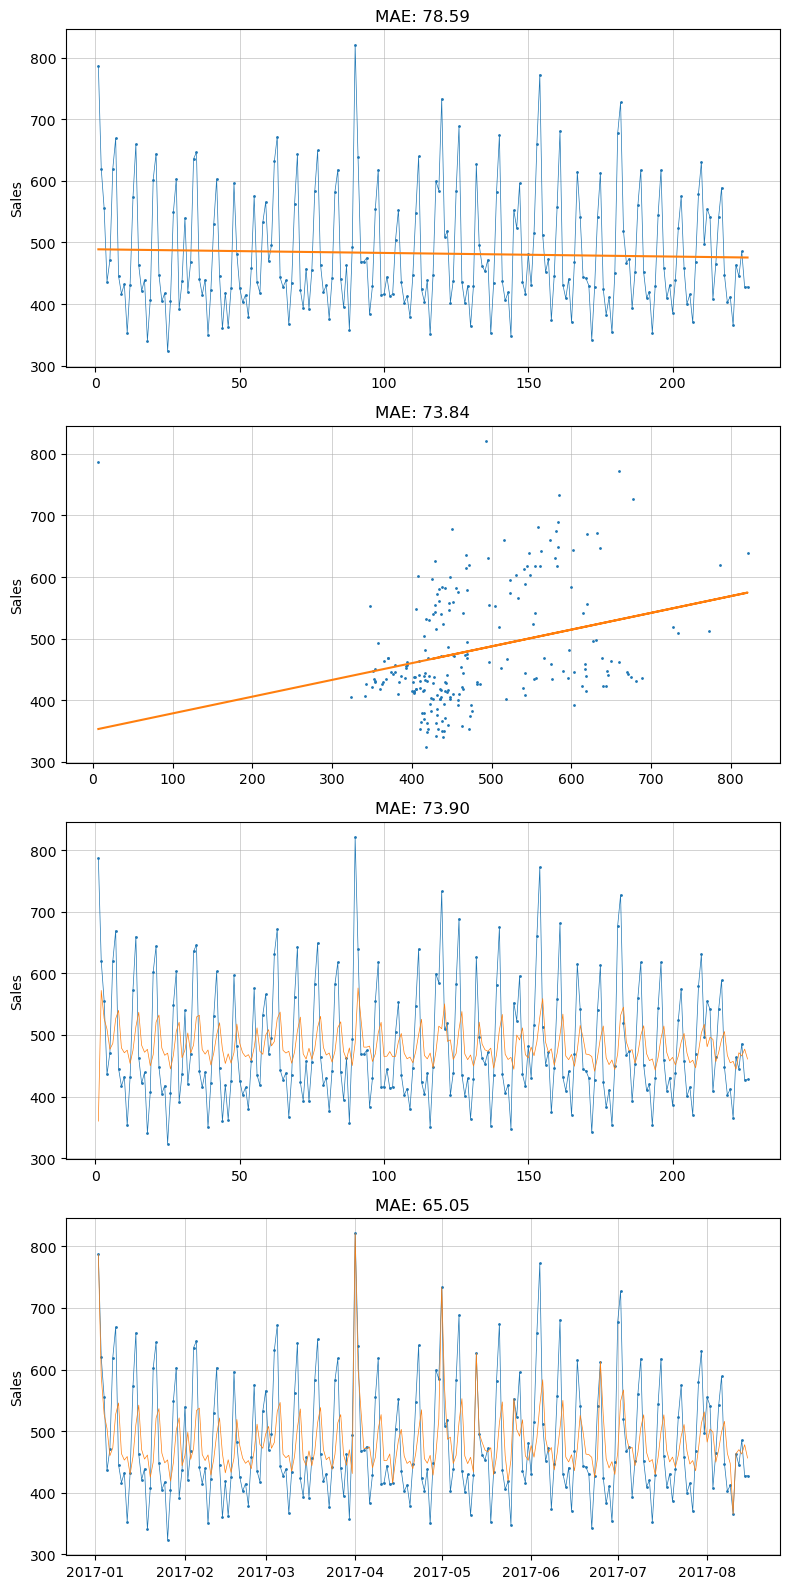

In [8]:
# Create different training sets with different features 
y = average_sales['sales']
X_time = average_sales.copy()
X_time.drop(['lag_1', 'sales'], axis=1, inplace=True)

X_lag_1 = average_sales.copy()
X_lag_1.drop(['time', 'sales'], axis=1, inplace=True)

X_full = average_sales.copy()
X_full.drop(['sales'], axis=1, inplace=True)

X_holidays['time'] = average_sales['time']
X_holidays['lag_1'] = average_sales['lag_1']
X_holidays.dropna(axis=0, inplace=True)
X_holidays.drop(['sales'], axis=1, inplace=True)

# Define a linear regression model
lin_reg = LinearRegression()

y_time, error_time = score_dataset(lin_reg, X_time, X_time, y, y)
y_lag_1, error_lag_1 = score_dataset(lin_reg, X_lag_1, X_lag_1, y, y)
y_full, error_full = score_dataset(lin_reg, X_full, X_full, y, y)
y_pred, error = score_dataset(lin_reg, X_holidays, X_holidays, y, y)

fig, axs = plt.subplots(4, 1, figsize=(8, 16), layout='tight')
for ax in axs:
    ax.grid(True, lw=0.4)
    ax.set_ylabel('Sales')

axs[0].set_title(f'MAE: {error_time:.2f}')
axs[0].plot(X_time['time'], y, marker='.', markersize=2, linewidth=0.5)
axs[0].plot(X_time['time'], y_time)

axs[1].set_title(f'MAE: {error_lag_1:.2f}')
axs[1].plot(X_lag_1['lag_1'], y, '.', markersize=2)
axs[1].plot(X_lag_1['lag_1'], y_lag_1)

axs[2].set_title(f'MAE: {error_full:.2f}')
axs[2].plot(X_full['time'], y, marker='.', markersize=2, linewidth=0.5)
axs[2].plot(X_full['time'], y_full, markersize=2, linewidth=0.5)

axs[3].set_title(f'MAE: {error:.2f}')
axs[3].plot(X_holidays.index.to_timestamp(), y, marker='.', markersize=2, linewidth=0.5)
axs[3].plot(X_holidays.index.to_timestamp(), y_pred, markersize=2, linewidth=0.5)

### Moving average plots and trends

Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year. To create a moving average, first we use the `rolling` method to begin a windowed computation. We follow this by the `mean` method to compute the average over the window. 

In [20]:
average_sales.head()

,sales
date,
2017-01-01,6.780303
2017-01-02,786.928406
2017-01-03,619.740234
2017-01-04,555.607971
2017-01-05,436.375397


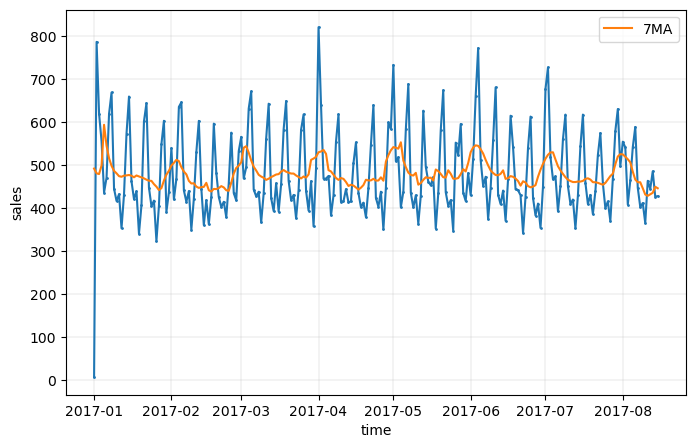

In [16]:
window_size = 7
min_periods = window_size//2
moving_average = average_sales.rolling(window=window_size,
                                       center=True, # puts the average at the center of the window
                                       min_periods=min_periods # choose about half the window size 
                                       ).mean() # compute the mean (could also be median, std, min, max, etc.)

fig, ax = plt.subplots(figsize=(8, 5))
ax.grid(True, lw=0.2)
ax.set_xlabel('time')
ax.set_ylabel('sales')
ax.plot(moving_average.index.to_timestamp(), average_sales['sales'], marker='.', markersize=2)
ax.plot(moving_average.index.to_timestamp(), moving_average['sales'], label=f'{window_size}MA')
ax.legend(loc='best')

As we can see this trend appears to be about **linear**. We can engineer the time dummy manually in pandas. However, from now on, we'll use a function from the `statsmodels` library called `DeterministicProcess`. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The order argument refers to polynomial order. A deterministic process refers to a time series that is non-random or completely determined. Features derived from the time index will generally be deterministic. 

In [ ]:
dp = DeterministicProcess(
    index=average_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

In [ ]:
X.head()

In [ ]:
y = average_sales['sales']

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model = model.fit(X, y)
y_pred = model.predict(X)

y_pred = pd.Series(y_pred, index=X.index)
error = mean_absolute_error(y, y_pred)

print(f'MAE: {error:.2f}')

fig, ax = plt.subplots(figsize=(8, 5))
ax.grid(True, lw=0.2)
ax.set_xlabel('time')
ax.set_ylabel('sales')
ax.plot(y.index.to_timestamp(), y, '.', markersize=2)
ax.plot(y_pred.index.to_timestamp(), y_pred)
# ax.legend(loc='best')

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast.

In [ ]:
X_fore = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

In [ ]:
X_fore.head()

In [ ]:
start_date = '2017-01-01'
fig, ax = plt.subplots(figsize=(8, 5))
ax.grid(True, lw=0.2)
ax.set_xlabel('time')
ax.set_ylabel('sales')
ax.plot(y[start_date:].index.to_timestamp(), y[start_date:], marker='.', markersize=3, linewidth=0.2)
ax.plot(y_pred[start_date:].index.to_timestamp(), y_pred[start_date:], label='trend')
ax.plot(y_fore.index.to_timestamp(), y_fore, label='trend forecast')
ax.legend(loc='best')

### Seasonality features

In [25]:
def seasonal_plot(df, target, period, freq, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    ax.grid(True, lw=0.2)
    for i in df[period].unique():
        subset = df[df[period] == i]
        subset = subset.groupby(freq).mean()
        ax.plot(subset.index, subset[target], label=str(i), alpha=0.7)
    ax.set_title(f'Seasonal plot: {period}/{freq}')
    ax.legend(loc='best')

def plot_periodogram(ts, detrend='linear', ax=None):
    
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
# add features for seasonal plots 
average_sales['day'] = average_sales.index.dayofweek
average_sales['week'] = average_sales.index.week
average_sales['dayofyear'] = average_sales.index.dayofyear
average_sales['month'] = average_sales.index.month
average_sales['year'] = average_sales.index.year

In [ ]:
average_sales

In [ ]:
seasonal_plot(average_sales, 'sales', 'week', 'day')

In [ ]:
plot_periodogram(average_sales['sales'])

Based on the periodogram, we will choose 4 Fourier features. To create the seasonal features, we will use again the `DeterministicProcess` utility. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term"

In [ ]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4) # 10 sin/cos pairs for Yearly seasonality

dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_trends = dp.in_sample()  # create features for dates in tunnel.index

In [ ]:
X_trends.head()

In [ ]:
y = average_sales['sales']

model = LinearRegression(fit_intercept=False)
model = model.fit(X_trends, y)

y_pred = model.predict(X_trends)
y_pred = pd.Series(y_pred, index=y.index)
error = mean_absolute_error(y, y_pred)
print(f'MAE: {error:.2f}')

X_fore = dp.out_of_sample(steps=30)
y_fore = model.predict(X_fore)
y_fore = pd.Series(y_fore, index=X_fore.index)

In [ ]:
start_date = '2017-01-01'

fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(True, lw=0.4)
ax.plot(y.index.to_timestamp(), y, marker='.', linewidth=0.6, color='lightgrey', label='sales data')
ax.plot(y_pred.index.to_timestamp(), y_pred, linewidth=0.4, label='prediction')
ax.plot(y_fore.index.to_timestamp(), y_fore, marker='.', color='red', linewidth=0.4, label='forecast')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend(loc='best')

### Detrending

Removing from a series its trend or seasons is called detrending or deseasonalizing the series

In [ ]:
y_deseason = y - y_pred 

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

# fig, ax = plt.subplots()
# ax.plot(y_deseason.index.to_timestamp(), y_deseason)

### Adding holidays to training set with seasonality

In [ ]:
X_trends.head()

In [ ]:
X_holidays.drop(['time', 'lag_1'], axis=1, inplace=True)

In [ ]:
X_holidays.head()

In [ ]:
X_full = X_trends.join(X_holidays)

In [ ]:
X_full

In [ ]:
model = LinearRegression(fit_intercept=False)
model = model.fit(X_full, y)

y_pred = model.predict(X_full)
y_pred = pd.Series(y_pred, index=y.index)
error = mean_absolute_error(y, y_pred)

# X_fore = dp.out_of_sample(steps=90)

# y_fore = model.predict(X_fore)
# y_fore = pd.Series(y_fore, index=X_fore.index)

fig, ax = plt.subplots(figsize=(13,4), layout='tight')
ax.grid(True, lw=0.2)
ax.set_title(f'MAE: {error:.2f}')
ax.plot(y.index.to_timestamp(), y, marker='.', color='brown', markersize=2, linewidth=0.5, label='sales data')
ax.plot(y.index.to_timestamp(), y_pred, linewidth=0.5, label='prediction')
ax.legend(loc='best')

### Lag plots, autocorrelation and partial correlation plots

In [ ]:
lags = [1, 2, 3, 4]

fig, axs = plt.subplots(1, len(lags), figsize=(16, 5), layout='tight')
for lag in lags:
    average_sales[f'lag_{lag}'] = average_sales['sales'].shift(lag)
    axs[lag-1].plot(average_sales[f'lag_{lag}'], average_sales['sales'], '.')
    axs[lag-1].set_xlabel('sales')
    axs[lag-1].set_ylabel('sales')
    axs[lag-1].set_title(f'Lag {lag}')

In [ ]:
_ = plot_pacf(average_sales['sales'], lags=20)

#### Cyclicity analysis using lag features

In [23]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
supply_sales.head()

,sales,onpromotion
family,SCHOOL AND OFFICE SUPPLIES,SCHOOL AND OFFICE SUPPLIES
date,,
2017-01-01,0.000000,0.0
2017-01-02,2.925926,0.0
2017-01-03,2.018518,0.0
2017-01-04,1.722222,0.0
2017-01-05,1.425926,0.0


/Users/tbrl/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


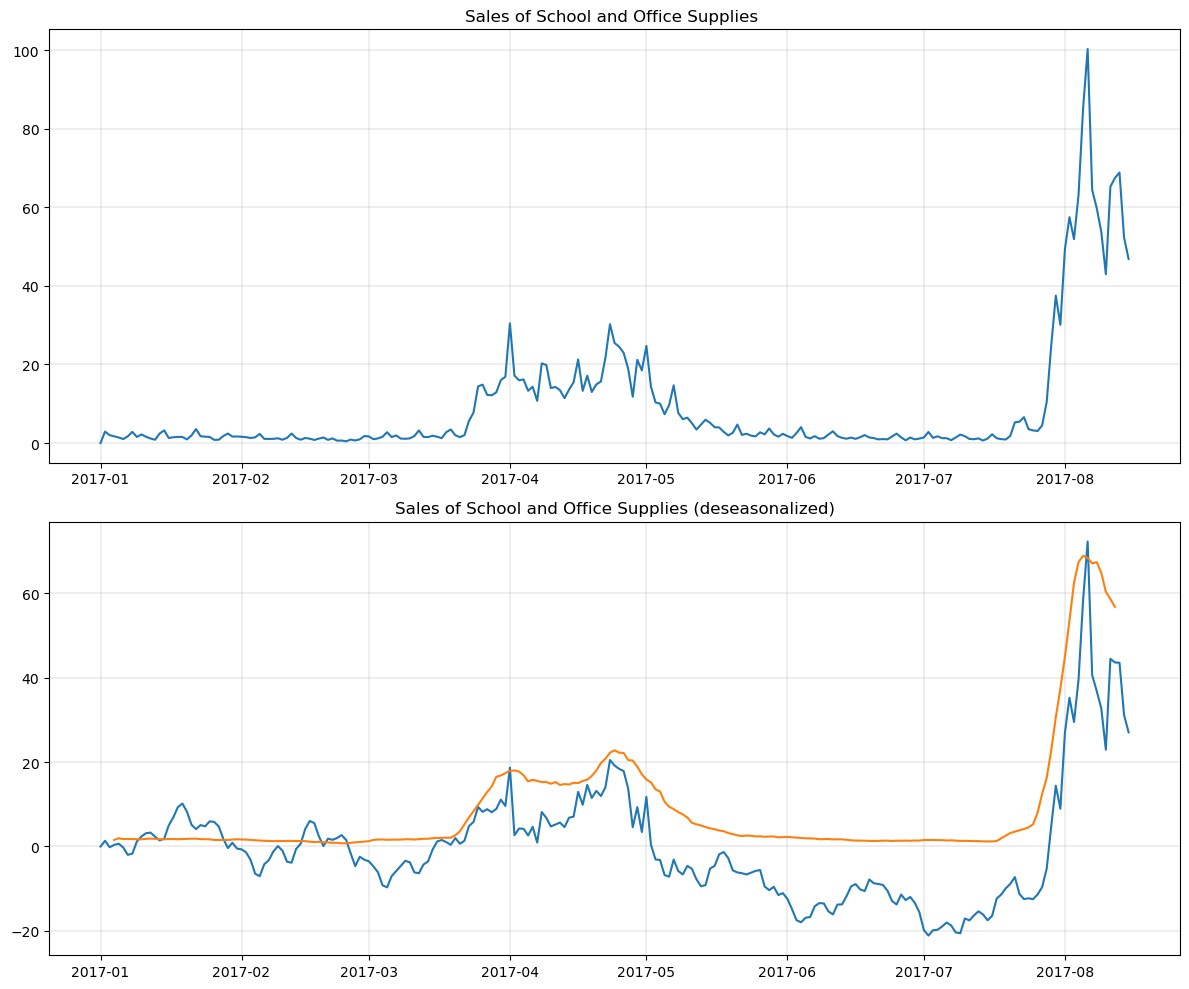

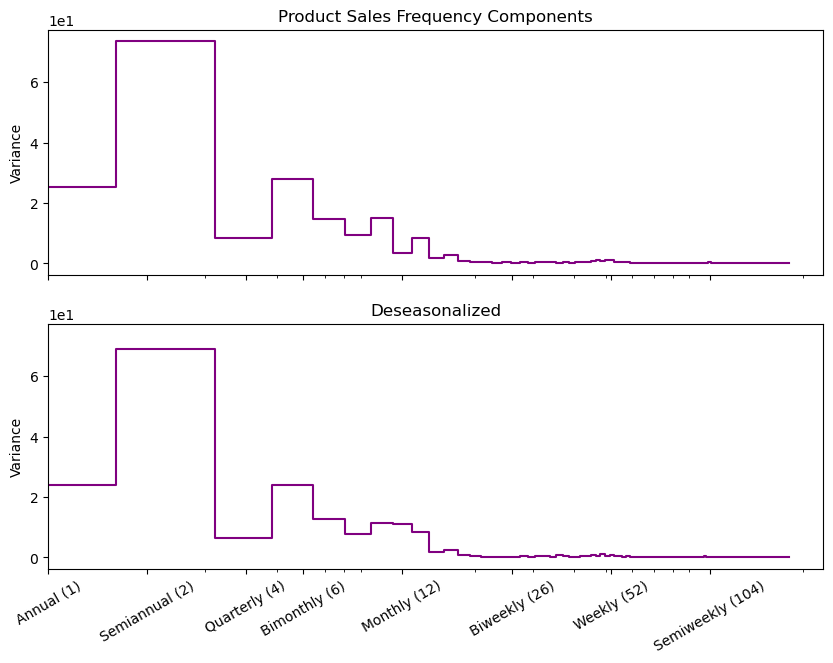

In [26]:
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier]
)

y_ma = y.rolling(window=7, 
                 center=True).mean()

X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear==1) # ??

model = LinearRegression(fit_intercept=False)
model = model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

fig, ax = plt.subplots(2, 1, figsize=(12, 10), layout='tight')
ax[0].grid(True, lw=0.3)
ax[0].set_title('Sales of School and Office Supplies ')
ax[0].plot(y.index.to_timestamp(), y)

ax[1].grid(True, lw=0.3)
ax[1].set_title('Sales of School and Office Supplies (deseasonalized)')
ax[1].plot(y_deseason.index.to_timestamp(), y_deseason)
ax[1].plot(y_ma.index.to_timestamp(), y_ma)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

### Creating statistical features

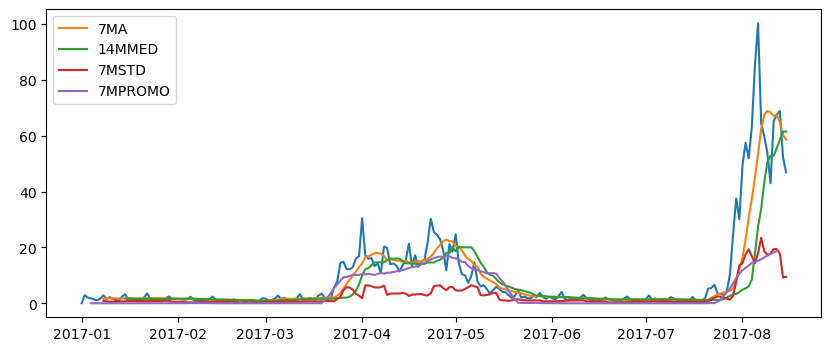

In [36]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

mean_7 = y_lag.rolling(7).mean()
median_14 = y_lag.rolling(window=14,
                         center=False).median()
std_7 = y_lag.rolling(window=7,
                     center=False).std()
promo_7 = onpromo.rolling(window=7,
                         center=True).sum()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_lag.index.to_timestamp(), y)
ax.plot(mean_7.index.to_timestamp(), mean_7, label='7MA')
ax.plot(median_14.index.to_timestamp(), median_14, label='14MMED')
ax.plot(std_7.index.to_timestamp(), std_7, label='7MSTD')
ax.plot(promo_7.index.to_timestamp(), promo_7, label='7MPROMO')
ax.legend(loc='best')

# Oil data processing

In [ ]:
# Add the time-step feature
oil_data['Time'] = np.arange(len(oil_data.index))

# Add the time-lag feature with step = 1
oil_data['Lag_1'] = oil_data['dcoilwtico'].shift(1)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for ax_i in ax:
    ax_i.grid(True, lw=0.3)
ax[0].plot(oil_data.index.to_timestamp(), oil_data['dcoilwtico'], lw=0.5)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Oil price')
ax[1].scatter(oil_data['Lag_1'], oil_data['dcoilwtico'], s=0.1)
ax[1].set_xlabel('Lag 1 oil price')
ax[1].set_ylabel('Oil price')

In [ ]:
# A simple linear regression model

X = oil_data.copy()

# Drop missing values 
X.dropna(axis=0, inplace=True)

# Set the target and remove it from the training set
y = X['dcoilwtico']
X.drop(['dcoilwtico'], axis=1, inplace=True)

lin_reg = LinearRegression()
lin_reg = lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)
error = mean_absolute_error(y, y_pred)
print(f'Mean absolute error: {error:.2f}')
# y_pred = pd.Series(y_pred, index=X.index)

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid(True, lw=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Oil price (USD)')
ax.plot(X.index, y, linewidth=0.5, c='orange')
ax.plot(X.index, y_pred, c='k', linewidth=1)
